In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
df = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car data.csv')
df.head()

In [ ]:
print('No of rows in dataset is ',df.shape[0],'and columns is',df.shape[1])

<h3>As observed from the data set we conclude that</h3> 
<h4> <ul> <li> Fuel_type</li> <li>Seller_type</li><li>Transmission</li><li>Owner</li> </h4><h3>is category features</h3>

In [ ]:
print('Categories of Seller_Type',df['Seller_Type'].unique())
print('Categories of Fuel_Type',df['Fuel_Type'].unique())
print('Categories of owner',df['Owner'].unique())
print('Categories of Transmission',df['Transmission'].unique())

In [ ]:
## check missing values
df.isnull().sum()

In [ ]:
df.describe()

Our objective is to predict selling price and according to year there might be a depreciation so we create a new feature of year - current_year(i.e. 2023) 

In [ ]:
## droping a Car_name as there will be many car name which will not effect our model
df.drop('Car_Name',axis=1,inplace =True) 
df['no_year'] = df.Year.apply(lambda x: 2020 - x)
## Now drop the Year column 
df.drop('Year',axis=1,inplace = True)

In [ ]:
df = pd.get_dummies(df,drop_first=True)
df.head() 

## Correlation analysis

In [ ]:
df.corr()

In [ ]:
 sns.pairplot(df)

In [ ]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
# plot heat map
g = sns.heatmap(df[top_corr_features].corr(),annot = True)

In [12]:
# independet and dependent feature
X = df.iloc[:,1:]
y = df.iloc[:,0]
y.head()

0    3.35
1    4.75
2    7.25
3    2.85
4    4.60
Name: Selling_Price, dtype: float64

## Ploting a feature importance graph to understande importance of feature for model

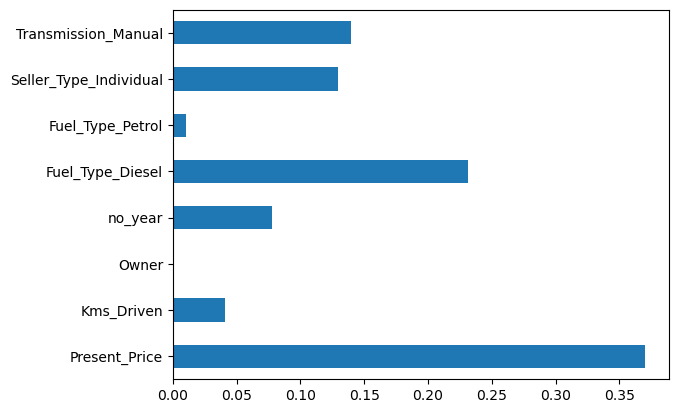

In [13]:
### Feature Importance 
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
feat_importance = pd.Series(model.feature_importances_,index = X.columns)
feat_importance.plot(kind ='barh')
plt.show()

# Split the data into train and test

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# random forest 
#### Using RandomizedSearchCV to tune parameter of random forest Regressoration estimator 

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# create the random grid 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf': min_samples_leaf}
random_grid

{'n_estimators': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 10, 15, 20, 25, 30],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10]}

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error')
rf_random.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error')

In [18]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30}

In [19]:
print("score of best model", rf_random.best_score_)

score of best model -2.1664696109166663


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

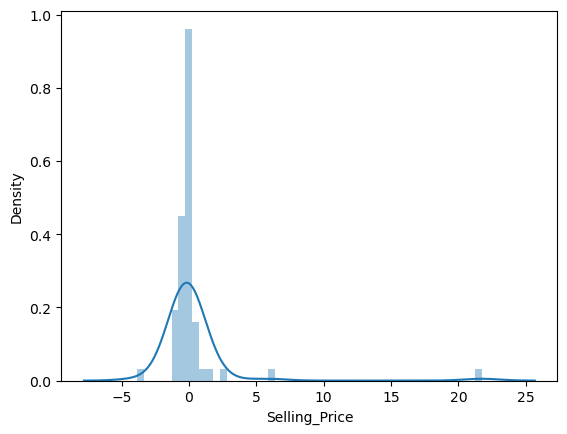

In [20]:
predictions = rf_random.predict(X_test)
sns.distplot(y_test-predictions) #plotting a error graph with y-axis as error 

In [1]:
from sklearn import metrics
print('Test Accuracy')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Test Accuracy


NameError: name 'y_test' is not defined

# Linear Regression

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

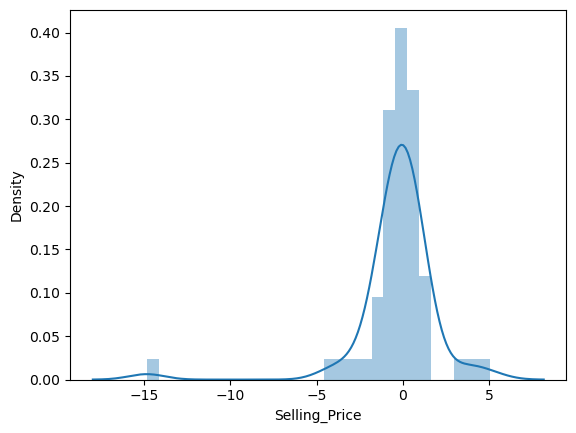

In [22]:
from sklearn.linear_model import LinearRegression
Ln = LinearRegression()
Ln.fit(X_train,y_train)
ln_predict = Ln.predict(X_test)
sns.distplot(y_test-ln_predict)

In [23]:
print('MAE:', metrics.mean_absolute_error(y_test,ln_predict ))
print('MSE:', metrics.mean_squared_error(y_test, ln_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ln_predict)))

MAE: 1.1728996119133102
MSE: 5.619398453113923
RMSE: 2.3705270412112838


# Support Vector Machine

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

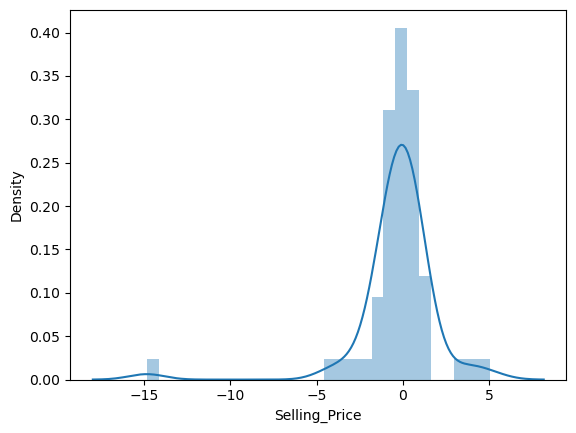

In [24]:
from sklearn import svm
sm = svm.SVR(kernel = 'rbf')
sm.fit(X_train,y_train)
sm_predict = Ln.predict(X_test)
sns.distplot(y_test-sm_predict)

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test,sm_predict ))
print('MSE:', metrics.mean_squared_error(y_test, sm_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, sm_predict)))

MAE: 1.1728996119133102
MSE: 5.619398453113923
RMSE: 2.3705270412112838
